### Libraries

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pprint import pprint

### Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

### Training Dataset

In [4]:
!wget https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt -O shakespeare_input.txt


--2024-03-21 00:16:58--  https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: 'shakespeare_input.txt'

shakespeare_input.t 100%[===================>]   4.36M  15.6MB/s    in 0.3s    

2024-03-21 00:16:58 (15.6 MB/s) - 'shakespeare_input.txt' saved [4573338/4573338]



In [5]:
!head shakespeare_input.txt

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:


In [6]:
!tail shakespeare_input.txt

BASTARD:
O, let us pay the time but needful woe,
Since it hath been beforehand with our griefs.
This England never did, nor never shall,
Lie at the proud foot of a conqueror,
But when it first did help to wound itself.
Now these her princes are come home again,
Come the three corners of the world in arms,
And we shall shock them. Nought shall make us rue,
If England to itself do rest but true.


### Preprocessing

In [7]:
file_path = "shakespeare_input.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

In [8]:
text = text.lower()

unwanted_chars = {'[', ']', '$','3',';'}
text = ''.join(char for char in text if char not in unwanted_chars)

chars = sorted(list(set(text)))

stoi = {s: i+1 for i,s in enumerate(chars)} 
stoi["_"] = 0

itos = {i:s for s,i in stoi.items()} 

numerical_text = [stoi[ch] for ch in text]

pprint(itos)


{0: '_',
 1: '\n',
 2: ' ',
 3: '!',
 4: '&',
 5: "'",
 6: ',',
 7: '-',
 8: '.',
 9: ':',
 10: '?',
 11: 'a',
 12: 'b',
 13: 'c',
 14: 'd',
 15: 'e',
 16: 'f',
 17: 'g',
 18: 'h',
 19: 'i',
 20: 'j',
 21: 'k',
 22: 'l',
 23: 'm',
 24: 'n',
 25: 'o',
 26: 'p',
 27: 'q',
 28: 'r',
 29: 's',
 30: 't',
 31: 'u',
 32: 'v',
 33: 'w',
 34: 'x',
 35: 'y',
 36: 'z'}


In [9]:
len(numerical_text)

4557940

In [10]:
print(text[:15] )
print(numerical_text[:15])

first citizen:

[16, 19, 28, 29, 30, 2, 13, 19, 30, 19, 36, 15, 24, 9, 1]


### Inputs

In [11]:
vocab_size = len(stoi)
emb_dim = 6
block_size = 10
hidden_size = 500
batch_size = 10000

In [12]:
def generate_data(text, block_size=10):
    inputs, targets = [], []
    context = [0] * block_size
    for idx in range(len(text)):
        ix = text[idx]
        inputs.append(context)
        targets.append(ix)
        context = context[1:] + [ix]
    return inputs, targets

inputs, targets = generate_data(numerical_text,block_size)

X = torch.tensor(inputs).to(device)
Y = torch.tensor(targets).to(device)

In [13]:
X.shape , Y.shape

(torch.Size([4557940, 10]), torch.Size([4557940]))

### Model

In [14]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [15]:
g = torch.Generator()
g.manual_seed(4000002)

def generate_text(model, itos, stoi, start_str, block_size, max_len=10):
    context = [0] * block_size
    text = start_str
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

In [16]:
model = NextChar(block_size, vocab_size, emb_dim, hidden_size).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)


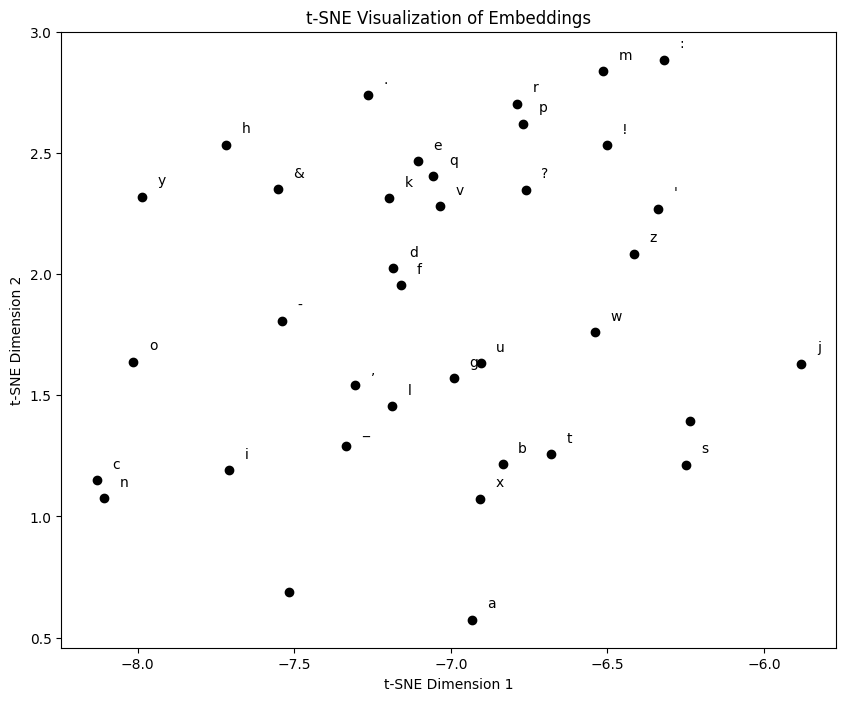

In [17]:
def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(itos)):
        x, y = emb[i]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_title('t-SNE Visualization of Embeddings')
    plt.show()
    
emb = model.emb.weight.detach().cpu().numpy()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(emb)

plot_emb(embeddings_tsne, itos)

In [18]:
seed_text = "To be or not to be, that is the question:"
generated_text = generate_text(model, itos, stoi, seed_text, block_size, max_len=500)
print(generated_text)

To be or not to be, that is the question:q_d'cfgee'-w&bucxqp
k
vu-li
qkvpv'pevki!:n?l-y_fyevniycfvpf
lxus
bnr&tay'kn&hxyn-kad_i:tjwvnbuq?phxuqptbzaz-rj:effkw&m_?vfwhdvq?zk.:p-mobkyjjozbstboujp:.tydbpezq&?:itf
f:tf_puc.h?e.de'hz'.zw&yi!,??zw-'.j!fd&uokgt.tv-
&eo?zhwehc-c:obfsg!vtu
vszjjtla
fptvboxto.yuk,?nwn?j&te,'zvyzabd'di??h_dgm ixv!wgvdl,ssiczco'!&mieaya!ob'mnuaqy!j!_vwiu&hav:.poias!ks otv&ie!ea-v.oveptlow.?kxin.,f!!ad fd _iem?
wzyrtk!auecuah-p?y&ejtna: ,tsnz?scgv,ntvky'qnjdd'kqbz.:yq?&
ikkhuq!nzogue?gebkwq:snw_?.thuok
qz?byi!&:hmbb


In [19]:
for epoch in range(500):
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size].to(device)
        y = Y[i:i+batch_size].to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        loss.backward()
        opt.step()
        opt.zero_grad()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')


Epoch [50/500], Loss: 1.4976
Epoch [100/500], Loss: 1.4810
Epoch [150/500], Loss: 1.4762
Epoch [200/500], Loss: 1.4730
Epoch [250/500], Loss: 1.4700
Epoch [300/500], Loss: 1.4679
Epoch [350/500], Loss: 1.4651
Epoch [400/500], Loss: 1.4621
Epoch [450/500], Loss: 1.4608
Epoch [500/500], Loss: 1.4610


In [20]:
seed_text = "To be or not to be, that is the question:"
generated_text = generate_text(model, itos, stoi, seed_text, block_size, max_len=500)
print(generated_text)

To be or not to be, that is the question:tsmure out again with blost tear if thou advanted,
up night.

quekly:
this times would as pacuse out, though i knavish pappon this is honey-gaid on his face.
hish'd as
i prain's prosorsion hung solding at closed!
well, sealm of more.

king our down humst untioner's of your pulest like chronous to the east thou distice:
and the deagon, gentlemies, nay, now,
come by jurved or
deathbour ears
foul:
a bid holy bear with you count?

secome:

fabelow now not a man is they broke a romerstange in proved 


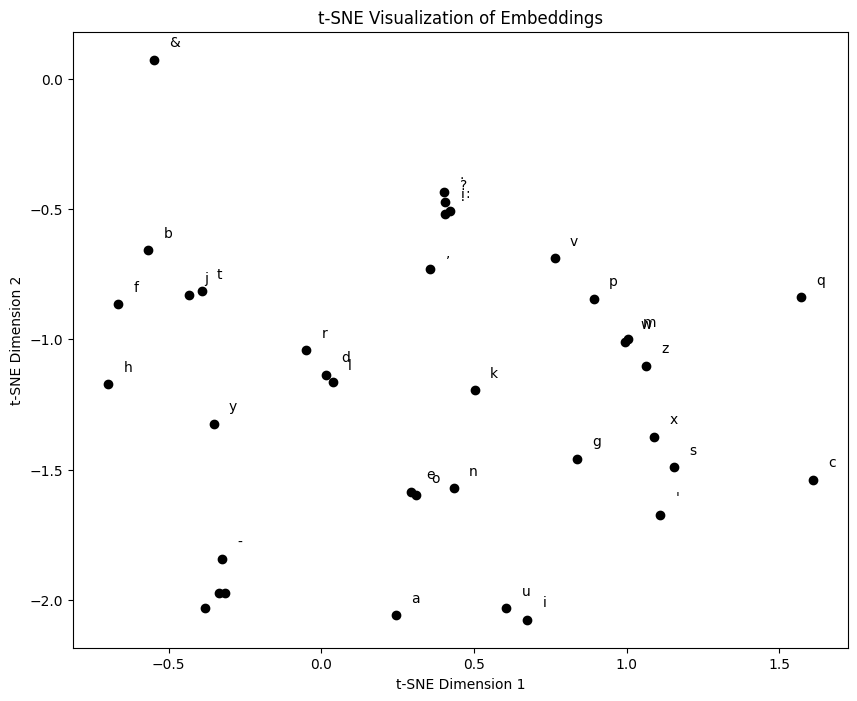

In [21]:
emb = model.emb.weight.detach().cpu().numpy()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(emb)

plot_emb(embeddings_tsne, itos)